<a href="https://colab.research.google.com/github/GIS-ZhangZhen/MangroveGreenness/blob/main/Estimating_trends_and_IAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import xarray as xr
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 1 Trend
We used the Mann-Kendall method to determine the signifcance of trend for each pixel and calculated the slope of trend by using the Theil–Sen regression. The significance $\alpha$ is 0.1 in this study, but we also produced the result at 0.05 significance level. Note that we only conducted the analysis for those pixels who have enough observations (> 20 years).

Defining functions to calculate trend

In [6]:
def k_cor(vector,y):
    count = np.count_nonzero(vector)
    if count < 20: 
        return np.nan,np.nan
    vector = vector/np.nanmean(vector)
    tau, p_value = stats.kendalltau(vector, y)
    slope = stats.mstats.theilslopes(vector)
    return slope[0], p_value

def kendall_correlation(x,y,dim='time'):
    return xr.apply_ufunc(
        k_cor, x , y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[] for _ in range(2)],  
        vectorize=True,
        dask='parallelized'
        )
def Trend(ds):
    dim = 'time'
    y = xr.DataArray(ds[dim].data, dims=dim, coords={dim: ds[dim]})
    r,p = kendall_correlation(ds,y,dim)
    r_sig10 = xr.where(p<=0.1,r,np.nan)
    r_sig5 = xr.where(p<=0.05,r,np.nan)
    return r_sig10,r_sig5,r,p

Import NIRv data

In [7]:
vi = 'NIRv'
EBF = xr.open_dataset('/content/drive/MyDrive/Greenness/VI/{0}_EBF_05deg.nc'.format(vi))
MGF = xr.open_dataset('/content/drive/MyDrive/Greenness/VI/{0}_MGF_05deg.nc'.format(vi))
EBF_trend = Trend(EBF)
MGF_trend = Trend(MGF)

Showing the spatial pattern of EBF/MGF trend with significant greening (red) or browning (blue)

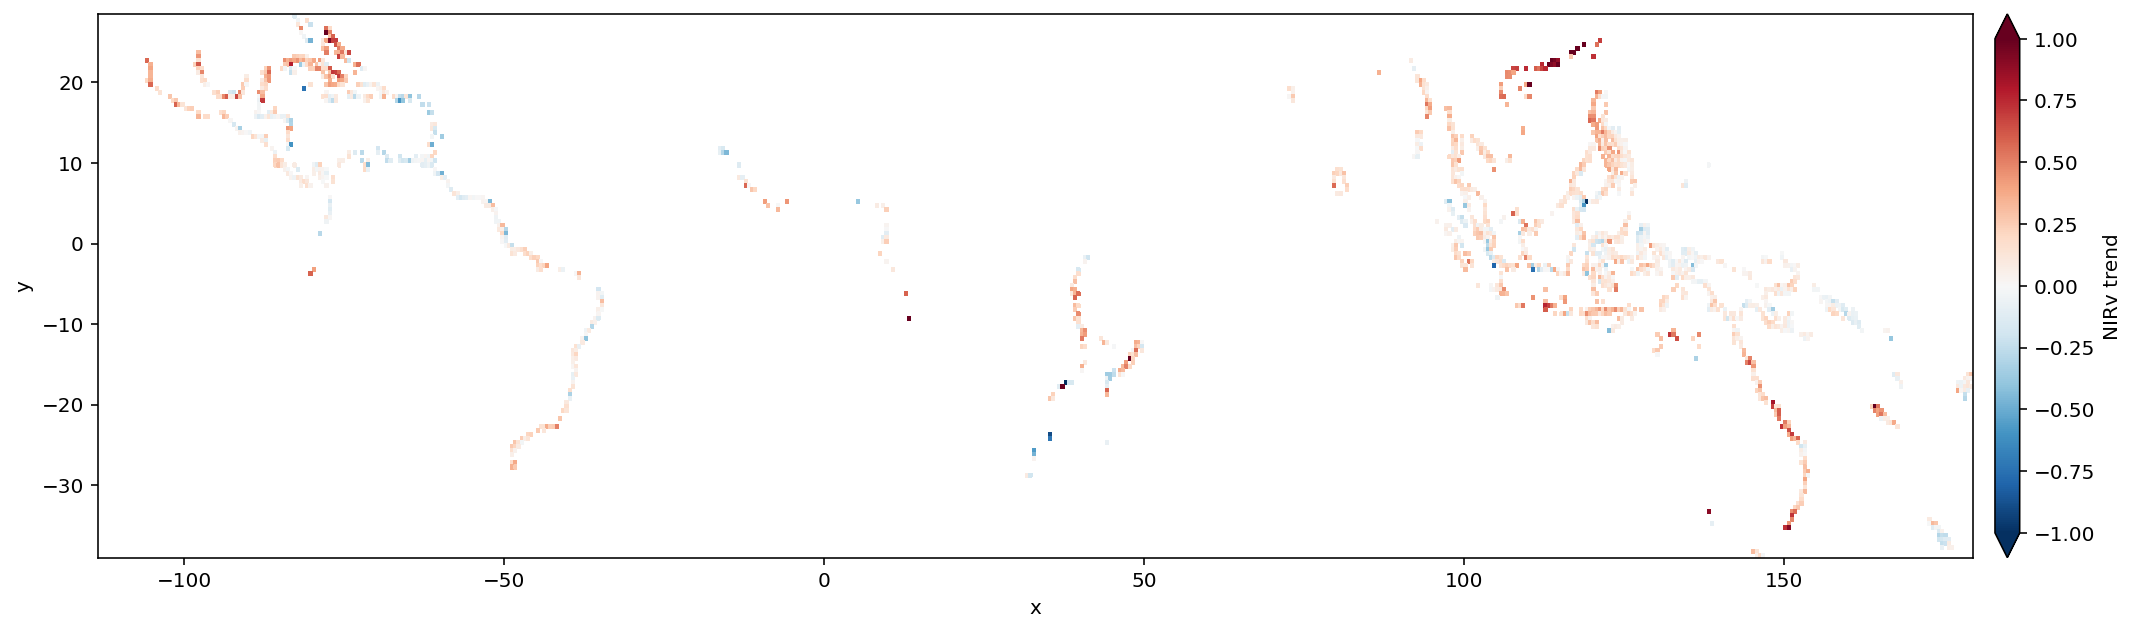

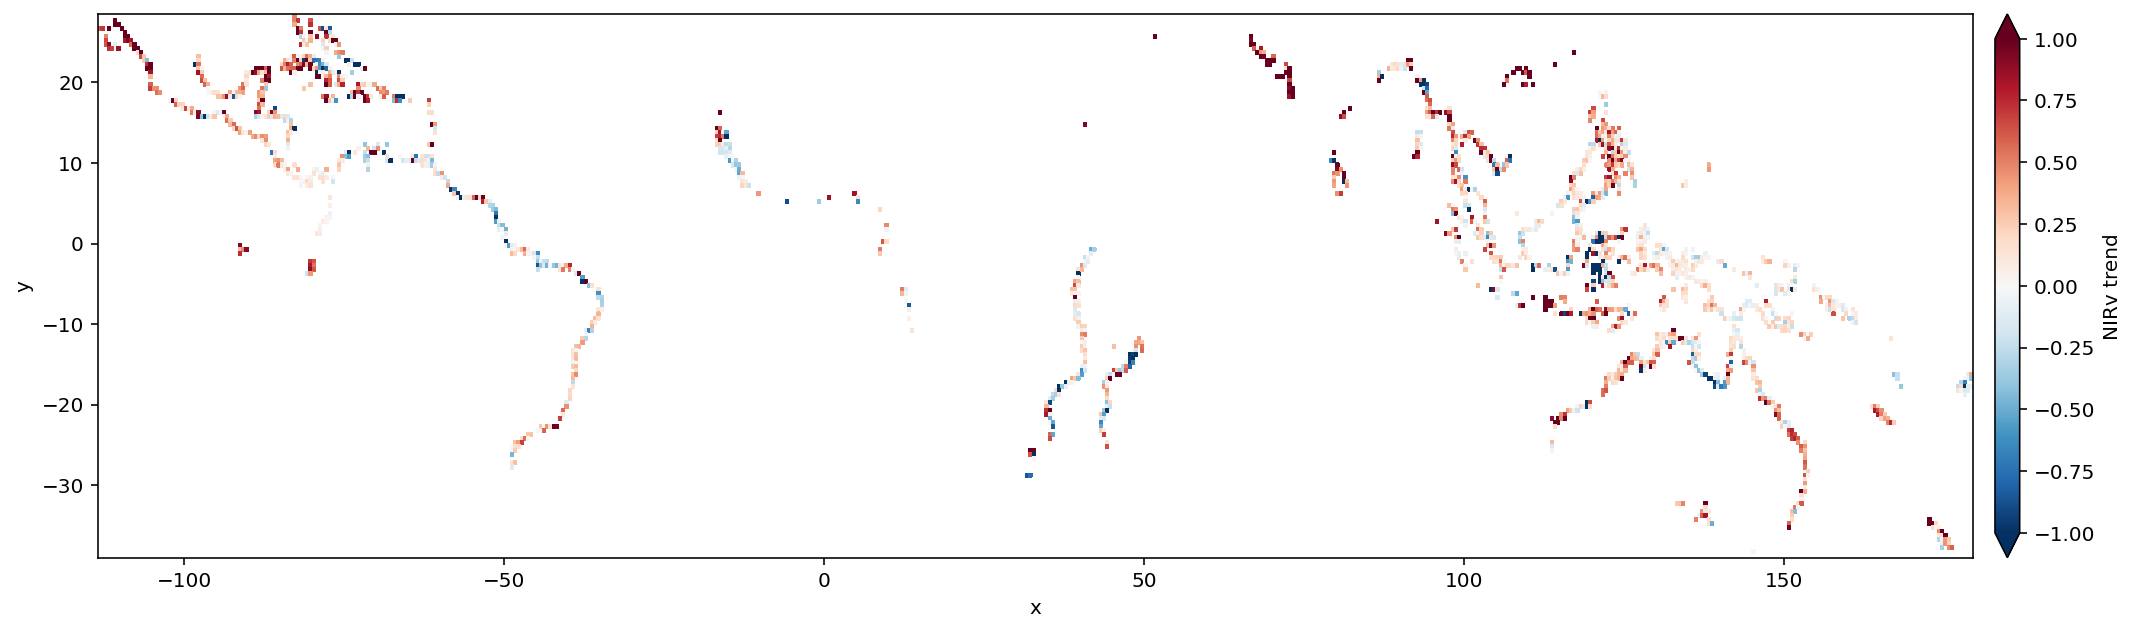

In [15]:
(EBF_trend[0][vi]*100).plot(vmax = 1, vmin = -1, cmap='RdBu_r',figsize=(20,5),cbar_kwargs={
        'label': 'NIRv trend',
        'pad':0.01
    })
(MGF_trend[0][vi]*100).plot(vmax = 1, vmin = -1, cmap='RdBu_r',figsize=(20,5),cbar_kwargs={
        'label': 'NIRv trend',
        'pad':0.01
    })

Save the results as the NetCDF format

In [ ]:
EBF_trend[3].to_netcdf('/content/drive/MyDrive/Greenness/VI/trend/{0}_EBF_Pval_trend_05deg.nc'.format(vi))
MGF_trend[3].to_netcdf('/content/drive/MyDrive/Greenness/VI/trend/{0}_MGF_Pval_trend_05deg.nc'.format(vi))

### 2 Inter-Annual Variability (IAV)
We used the Coefficient of Variability (CV) to quantify IAV for each pixel. 
$$CV = \frac{\sigma_{d}}{\mu}$$
where $\sigma_{d}$ is the standard deviation of linear-detrended NIRv, $\mu$ is the mean value of raw NIRv (because the mean value of detrended NIRv always equals to zero). The detrended *SD* could make us to disentangle the effect of annual trend. As an example, *CV* equals to 0.3 represents that the detrended *SD* is 30 percent of the raw average. 

Note that we only conducted the analysis for those pixels who have enough observations (> 20 years). 



In [23]:
from sklearn.linear_model import LinearRegression

def CV(Y,t):
    count = np.count_nonzero(Y)
    if count < 20: 
        return np.nan
    t = t.reshape(-1,1)
    model = LinearRegression()
    model.fit(t,Y)
    trend = model.predict(t)
    detrended = Y-trend
    std = np.nanstd(detrended)
    mean = np.nanmean(Y)
    CV = std/mean #detrended std/raw mean
    return CV

def IAV(ds,dim='time'):
    t = xr.DataArray(ds[dim].data, dims=dim,
                    coords={dim: ds[dim]}) 
    return xr.apply_ufunc(
        CV, ds, t,
        input_core_dims=[[dim],[dim]],
        output_core_dims=[[] for _ in range(1)],  
        vectorize=True,
        dask='parallelized')

EBF_IAV = IAV(EBF)
MGF_IAV = IAV(MGF)

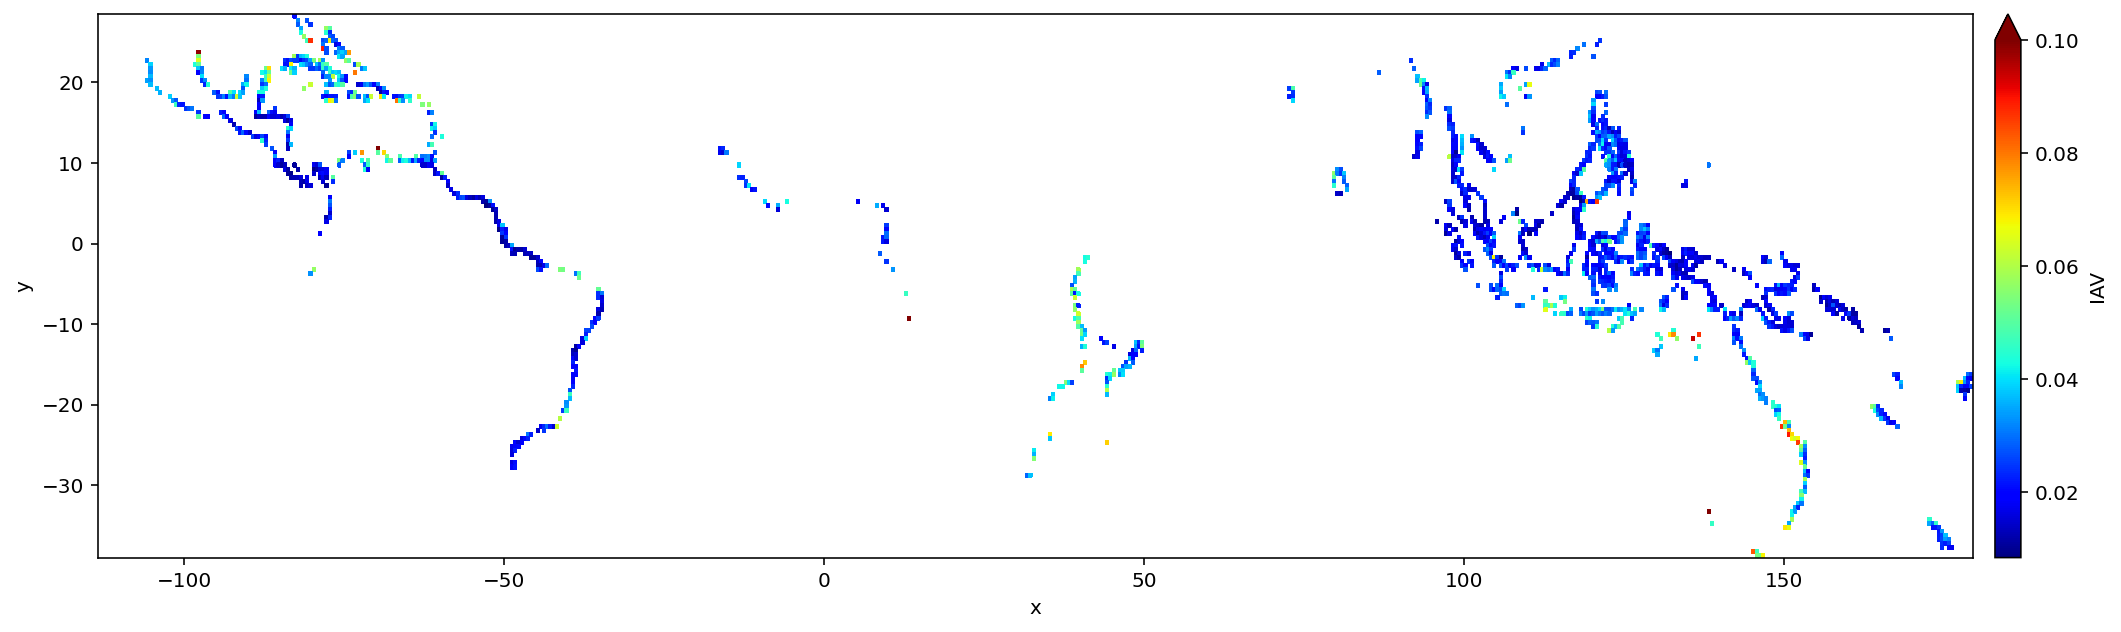

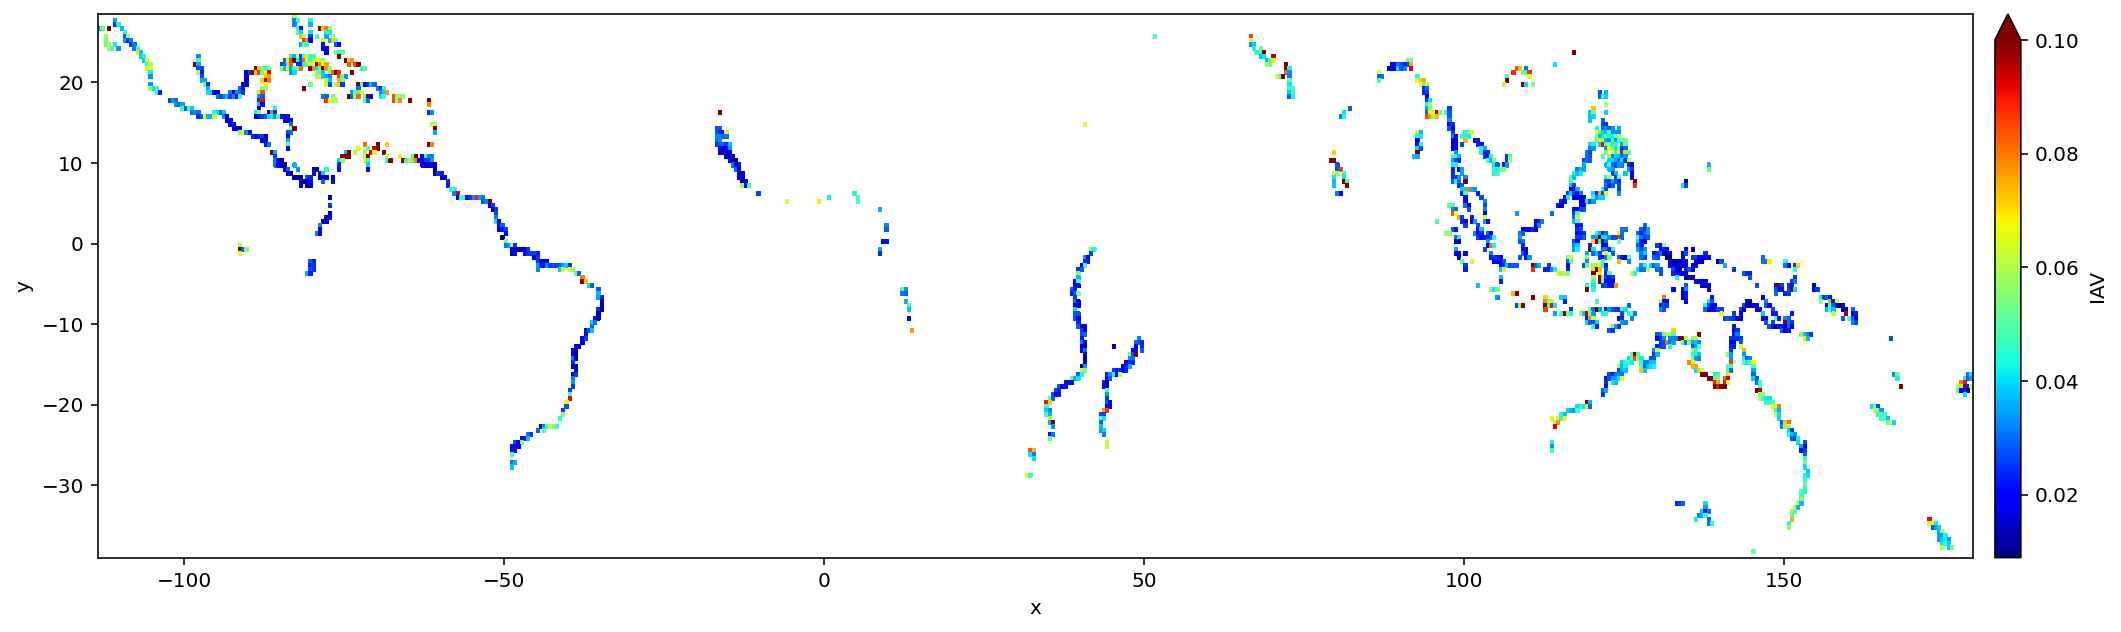

In [20]:
EBF_IAV[vi].plot(vmax = 0.1,cmap='jet',figsize=(20,5),cbar_kwargs={
        'label': 'IAV',
        'pad':0.01})
MGF_IAV[vi].plot(vmax = 0.1,cmap='jet',figsize=(20,5),cbar_kwargs={
        'label': 'IAV',
        'pad':0.01})